## Data Loading
Let's load the data and take a look into what is in there and how we can use it

In [ ]:
#Install packages needed
!pip install -r requirements.txt

In [1]:
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
%matplotlib inline

lets load the data from the csv file generated by the scraper

In [2]:
df = pd.read_csv('./get_data/crawl_data.csv')
brands = pd.DataFrame(df.brand.unique()).sort_values(0).reset_index(drop=True)
display(brands)
print('Nº of different engines %s' % len(df.engine.unique()))
df.info()


,0
0,Alfa Romeo
1,Audi
2,BMW
3,Brilliance
4,Chana
5,Changan
6,Changhe
7,Chery
8,Chevrolet
9,Chrysler


Nº of different engines 302
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 16 columns):
brand           2016 non-null object
color           2016 non-null object
engine          1715 non-null object
fuel            1744 non-null object
id              2016 non-null object
image_urls      2016 non-null object
images          2005 non-null object
location        2016 non-null object
mileage         2016 non-null int64
model           2016 non-null object
onlyOwner       1199 non-null object
price           2016 non-null object
steering        2016 non-null object
traction        1405 non-null object
transmission    2016 non-null object
year            2016 non-null int64
dtypes: int64(2), object(14)
memory usage: 252.1+ KB


There is a lot of different type of engines, they are all in different formats (some ar in liters others in C.C),  and some don't even have that, they just put the name.

Because of this there is not an accesible way to make this information reliable so I choose to delete it.

In [3]:
df = df.drop(columns=['engine', 'image_urls', 'images'])
display(df.head())

,brand,color,fuel,id,location,mileage,model,onlyOwner,price,steering,traction,transmission,year
0,Volkswagen,Negro,Gasolina,MCO477026829,El vehículo está en Cedritos - Usaquén - Bogot...,0,Gol,Sí,34.990.000,Asistida,NaN,Mecánica,2019
1,Hyundai,Otro,Gasolina,MCO481357221,El vehículo está en Perpetuo Socorro - Medellí...,0,Tucson,Sí,90.990.000,Asistida,4x2,Automática,2018
2,Chevrolet,Gris,Gasolina,MCO483493511,El vehículo está en Turin - Pereira - Risaralda,102973,Aveo,NaN,16.500.000,Hidráulica,NaN,Mecánica,2008
3,Chevrolet,Plateado,Gasolina,MCO485896179,El vehículo está en Normandía - Engativa - Bog...,63000,Captiva,NaN,28.900.000,Hidráulica,NaN,Automática,2011
4,Volkswagen,Blanco,Gasolina,MCO477152685,El vehículo está en Cedritos - Usaquén - Bogot...,0,Golf,Sí,109.990.000,Asistida,4x2,Automática,2019


next variable to be deal with is the location, this starts with *El vehículo está en* wich needs to be removed, and its also separated by hyphens that also need to be removed

In [4]:
def clean_location(locations, starts_with='El vehículo está en ',):
    location_only_places = locations.str.replace(starts_with, '')
    locations_split = location_only_places.str.split('-')
    location_reverse = locations_split.apply(reversed).apply(list)
    return location_reverse

def get_state_city(location):
    return pd.DataFrame(location.values.tolist())[[0,1]]
    
loc_temp = clean_location(df.location)
df_locations = get_state_city(loc_temp)
df_locations.columns = ['State', 'City']
df = pd.concat([df,df_locations], axis=1)
df = df.drop(columns=['location'])
df = df.set_index('id')

Now lets do some data exploration.

The first thing its see the distribution of our data. One that interest me its how many samples of each car and models do we have

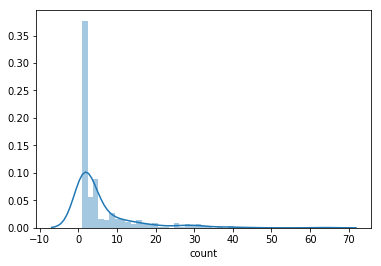

In [5]:
sns.distplot(df.groupby(['brand','model']).size().reset_index().rename(columns={0: 'count'})['count']);

As expected this distribution its highly skewed, which means that we have an over representation of some car and models and under representation of other. This makes sense since some cars an brands are more popular in the market than others.

In [6]:
df['price'] = df['price'].map(lambda x: x.replace('.', '')).astype(int)
print('Mean   {}'.format(df['price'].mean()))
print('STD    {}'.format(df['price'].std()))
print('Median {}'.format(df['price'].median()))
print('IQR    {}'.format(scipy.stats.iqr(df['price'])))

Mean   56487816.79365079
STD    48814677.612826034
Median 43900000.0
IQR    43500000.0


The standard deviation its quite large compare to the mean, plus the fact that the mean its well above the median leads me to believe that there multiple outliers, to confirm this let's lock a boxplot

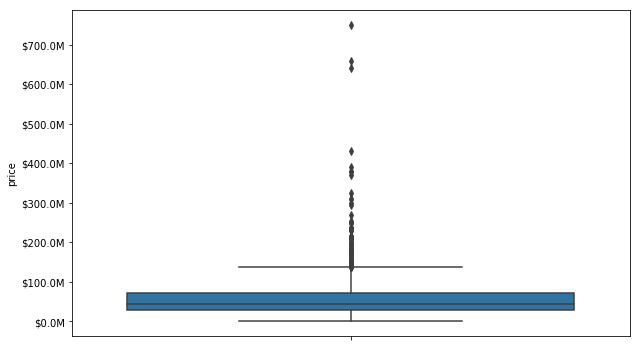

In [7]:
#plt.hist(df['price'], density=True, alpha=0.7)
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)
plt.figure(figsize=(10,6));

ax = sns.boxplot(y='price', data=df);
ax.yaxis.set_major_formatter(formatter);

That its interesting, there seams to be a large number of *"outliers"*, lets see at least the ones over the 0.99 quantile

In [8]:
df[df['price'] > df['price'].quantile(0.99)]

,brand,color,fuel,mileage,model,onlyOwner,price,steering,traction,transmission,year,State,City
id,,,,,,,,,,,,,
MCO482030566,Toyota,Blanco,Diesel,0,Prado,NaN,310000000,Asistida,4x4,Automática,2018,Magdalena,Santa Marta (distrito Turistico Cultural E His...
MCO487849596,Lexus,Blanco,Gasolina,30600,GX,Sí,233000000,Asistida,4x4,Automática,2016,Casanare,Yopal
MCO487147406,Toyota,Blanco,Gasolina,0,LC200,NaN,430000000,Asistida,4x4,Automática,2019,Bogotá D.c.,Bogota
MCO486658262,BMW,Blanco,NaN,1500,Serie 6,NaN,250000000,Asistida,NaN,Automática,2014,Cundinamarca,Bogota
MCO484464269,Toyota,Blanco,NaN,0,LC200,NaN,390000000,Asistida,NaN,Automática,2019,Bogotá D.c.,Bogota
MCO485693920,BMW,Blanco,NaN,12450,X5,NaN,250000000,Hidráulica,NaN,Automática,2016,Norte De Santander,Cúcuta
MCO487847418,Lexus,Blanco,Gasolina,30600,GX,Sí,233000000,Asistida,4x4,Automática,2016,Bogotá D.c.,Bogota
MCO482103954,Mercedes Benz,Blanco,Gasolina,0,Clase GL,Sí,660000000,Hidráulica,4x4,Automática,2018,Bogotá D.c.,Bogota
MCO482030739,Lexus,Blanco,Gasolina,0,LX,NaN,640000000,Asistida,4x4,Automática,2018,Bogotá D.c.,Bogota


As expected all this cars are considered luxury cars, which makes sense why this cars are in this price range,
Now the next question is, what happen with the other extreme, the incredibly cheap ones, lets see what they are

In [9]:
df[df['price'] < df['price'].quantile(0.01)]

,brand,color,fuel,mileage,model,onlyOwner,price,steering,traction,transmission,year,State,City
id,,,,,,,,,,,,,
MCO482030786,Toyota,Blanco,Diesel,0,Sahara,NaN,154000,Hidráulica,4x4,Automática,2019,Bogotá D.c.,Bogota
MCO487474462,Chevrolet,Plateado,Gasolina,66000,Spark GT,NaN,26900,Asistida,NaN,Mecánica,2012,Bogotá D.c.,Bogota
MCO482030578,Toyota,Blanco,Diesel,0,Land Cruiser,NaN,60000,Hidráulica,4x4,Mecánica,2018,Magdalena,Santa Marta (distrito Turistico Cultural E His...
MCO482030675,Toyota,Gris,Diesel,0,Prado,NaN,107000,Asistida,4x4,Automática,2018,Bogotá D.c.,Bogota
MCO490476980,Hyundai,Negro,Gasolina,196630,Tucson,No,23900,Hidráulica,4x4,Automática,2006,Bogotá D.c.,Suba
MCO490071318,Chevrolet,Blanco,Gasolina,35800,Sail,Sí,24900,Hidráulica,NaN,Mecánica,2014,Bogotá D.c.,Bogota
MCO482030575,Lexus,Negro,Gasolina,0,GX,NaN,130000,Hidráulica,4x4,Automática,2018,Magdalena,Santa Marta (distrito Turistico Cultural E His...
MCO487265016,Nissan,Blanco,Gasolina,80100,X-Trail,NaN,40900,Asistida,4x4,Automática,2011,Bogotá D.c.,Bogota
MCO490092297,BMW,Plateado,Gasolina,85400,X5,NaN,79900,Hidráulica,NaN,Automática,2009,Bogotá D.c.,Suba


In this situation we see something slightly different, we observe a list of cars, some of which are known to be economic,
but there are also luxury cars that have been wrongly priced.

Now lets look at the mileage

Mileage (in Kms)
Mean   66608.26041666667
STD    58054.89558654298
Median 58938.0
IQR    63500.0
Skewness 3.0063560629475568
Kurtosis 24.900068176214113


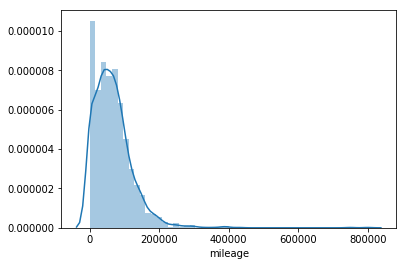

In [10]:
print('Mileage (in Kms)')
print('Mean   {}'.format(df['mileage'].mean()))
print('STD    {}'.format(df['mileage'].std()))
print('Median {}'.format(df['mileage'].median()))
print('IQR    {}'.format(scipy.stats.iqr(df['mileage'])))

print('Skewness {}'.format(scipy.stats.skew(df['mileage'])))
print('Kurtosis {}'.format(scipy.stats.kurtosis(df['mileage'])))
sns.distplot(df['mileage']);

Year
Mean   2012.3501984126983
STD    5.581018874074131
Median 2013.0
IQR    5.0
Skewness -2.2876420735622043
Kurtosis 9.633553006260971


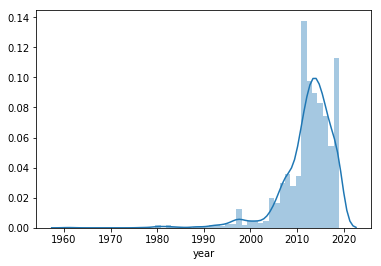

In [11]:
print('Year')
print('Mean   {}'.format(df['year'].mean()))
print('STD    {}'.format(df['year'].std()))
print('Median {}'.format(df['year'].median()))
print('IQR    {}'.format(scipy.stats.iqr(df['year'])))

print('Skewness {}'.format(scipy.stats.skew(df['year'])))
print('Kurtosis {}'.format(scipy.stats.kurtosis(df['year'])))
sns.distplot(df['year']);

Now lets see what are the most popular brands in our dataset

In [12]:
sorted_brands_by_sample_size = df.groupby('brand').size().sort_values(ascending=False)
most_popular_brands = sorted_brands_by_sample_size.where(sorted_brands_by_sample_size > 50).dropna()
display(most_popular_brands)

brand
Chevrolet        264.0
Ford             184.0
Renault          175.0
Toyota           166.0
Kia              154.0
Mazda            135.0
Nissan           116.0
BMW              101.0
Volkswagen       100.0
Hyundai           96.0
Mercedes Benz     72.0
Honda             54.0
dtype: float64

Now lets see the relation between **mileage**, **year** and **price** for the most popular brans

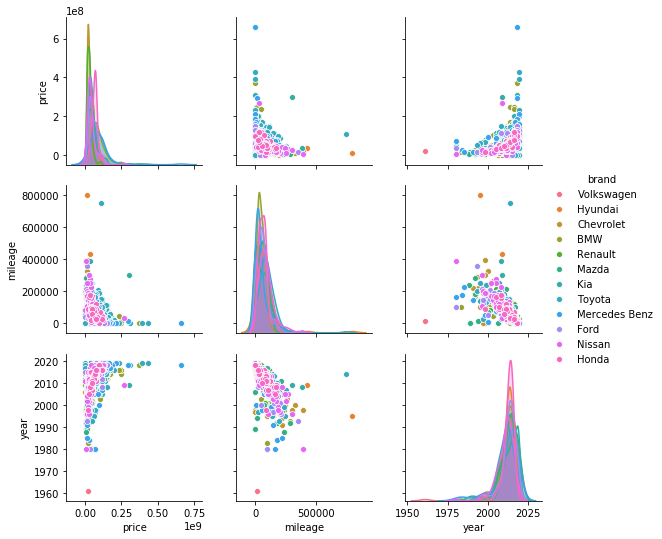

In [13]:
reduce_df = df[df['brand'].isin(most_popular_brands.index)]
sns.pairplot(data=reduce_df[['price', 'mileage', 'year', 'brand']], hue='brand')

In [14]:
price_mileage_cor, price_mileage_pv = scipy.stats.spearmanr(reduce_df['price'], reduce_df['mileage'])
price_year_cor, price_year_pv = scipy.stats.spearmanr(reduce_df['price'], reduce_df['year'])
mileage_year_cor, mileage_year_pv = scipy.stats.spearmanr(reduce_df['mileage'], reduce_df['year'])
print('Correlation between price and mileage is {} and its p-value {}'.format(price_mileage_cor, price_mileage_pv))
print('Correlation between price and year is {} and its p-value {}'.format(price_year_cor, price_year_pv))
print('Correlation between year and mileage is {} and its p-value {}'.format(mileage_year_cor, mileage_year_pv))

Correlation between price and mileage is -0.46982726351725984 and its p-value 1.4437257092972059e-89
Correlation between price and year is 0.5190113004003902 and its p-value 3.283263018896982e-112
Correlation between year and mileage is -0.8502771076223804 and its p-value 0.0


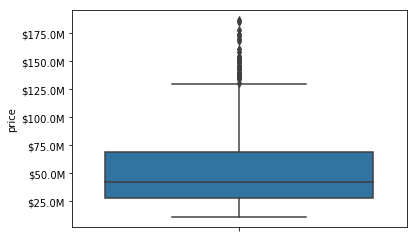

In [135]:
# removing outliers
over = reduce_df['price'].quantile(0.75) + 3*scipy.stats.iqr(reduce_df['price']) # removes values 
under = reduce_df['price'].quantile(0.01) 
reduce_df = reduce_df[(reduce_df['price'] > under) & (reduce_df['price'] < over)]
ax = sns.boxplot(y='price', data=reduce_df);
ax.yaxis.set_major_formatter(formatter);

# Predict

For the most popular brands of cars lets make a prediction of a price given the parameters that we have


In [136]:
from sklearn.base import TransformerMixin, BaseEstimator

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
    def inverse_transform(self, X, y=None):
        return X


In [137]:
class MultiLabelEncoder(TransformerMixin):
    def __init__(self):
        self.column_encoding = []
        
    def fit(self, X, y=None):
        self.original_column_order = X.columns
        return self
        
    def transform(self, X, y=None):
        output = X.copy()
        for column in output.columns:
            if output[column].dtype.name == 'category':
                # Applies dummie encoding
                new_df = pd.get_dummies(output[column], prefix=column)
                cols = new_df.columns
                # Saves information for inverse transform
                self.column_encoding.append({
                    'column': column,
                    'new_columns': cols,
                });
                # Add the new columns and delete the previus ones.
                output = pd.concat([output, new_df], axis=1).drop(columns=[column])
        return output
    
    def inverse_transform(self, X, y=None):
        back = X.copy()
        for encoding in self.column_encoding:
            # Unifie the columns
            new_out = back[encoding['new_columns']].idxmax(axis=1)
            # Remove the prefix
            new_out_clean = new_out.map(lambda x: x.replace(encoding['column']+'_', ''))
            # Add the new columns and remove the previeus ones.
            new_clean_df = pd.DataFrame(data=new_out_clean, columns=[encoding['column']])
            back = pd.concat([new_clean_df, back], axis=1).drop(columns=encoding['new_columns'])
        return back[self.original_column_order]
    


In [138]:
class DataFrameCategorical(TransformerMixin):
    
    def __init__(self, categorical_columns):
        super()
        self.categorical_columns = categorical_columns
        self.encoding = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        output = X.copy()
        for column in self.categorical_columns:
            original_dtype = output[column].dtype
            self.encoding.append({
                'original_dtype': original_dtype,
                'column': column
            });
            output[column] = output[column].astype('category')
        return output
    
    def inverse_transform(self, X):
        output = X.copy()
        print(self.encoding)
        for enc in self.encoding:
            output[enc['column']] = output[enc['column']].astype(enc['original_dtype'])
        return output

In [139]:
from sklearn.pipeline import Pipeline

categorical_columns=['brand', 'color', 'fuel', 'onlyOwner', 'steering', 'traction', 'State']

pipe = [
    ('imputer', DataFrameImputer()), 
    ('Categorical', DataFrameCategorical(categorical_columns=categorical_columns)),
    ('labelEncoder', MultiLabelEncoder())
]
data_pipe = Pipeline(pipe)

In [140]:
from sklearn.linear_model import LinearRegression
import math

working_df = data_pipe.fit_transform(reduce_df)
test_size = math.floor(working_df.shape[0] * 0.1) # 10%

rows = np.random.choice(working_df.index.values, test_size)
test_df = working_df.loc[rows]
train_df = working_df.drop(rows)

In [141]:
working_df.shape[0]

1565

156

1413

1569

(158,)

-1425